In [2]:
from __future__ import print_function
import imageio
import tensorflow as tf
from numpy.random import seed
seed(1)
import numpy as np
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import os
import h5py
import scipy.io as sio
import cv2
import glob
import gc
from tensorflow import keras as keras
from keras.models import load_model, Model, Sequential
from keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                          Activation, Dense, Dropout, ZeroPadding2D)
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from keras.layers.advanced_activations import ELU

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# CHANGE THESE VARIABLES ---
data_folder = 'E:/JuniorYearSpring/ECE397/fall_detection/URFD_opticalflow/Falls/fall_fall-09'
mean_file = 'E:/JuniorYearSpring/ECE397/fall_detection/flow_mean.mat'
vgg_16_weights = 'E:/JuniorYearSpring/ECE397/fall_detection/weights.h5'
save_features = False
save_plots = True

# Set to 'True' if you want to restore a previous trained models
# Training is skipped and test is done
use_checkpoint = False # Set to True or False
# --------------------------

best_model_path = 'models/'
plots_folder = 'plots/'
checkpoint_path = 'models/fold_'

features_file = 'features_urfd_tf.h5'
labels_file = 'labels_urfd_tf.h5'
features_key = 'features'
labels_key = 'labels'

L = 10
num_features = 4096
batch_norm = True
learning_rate = 0.0001
mini_batch_size = 0
weight_0 = 1.0
epochs = 1000

# Name of the experiment
exp = 'urfd_lr{}_batchs{}_batchnorm{}_w0_{}'.format(learning_rate,
                                               mini_batch_size,
                                               batch_norm,
                                               weight_0)


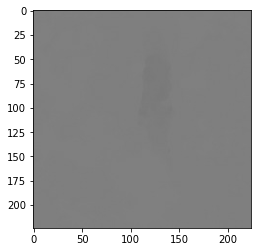

In [4]:
%matplotlib inline 
I = tf.read_file(data_folder+"/flow_x_00001.jpg")
I = tf.image.decode_jpeg(I, channels=3) 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    I=sess.run((I))
#     print (I.shape) 
#     print (I)
    plt.imshow(I) 

In [5]:
def plot_training_info(case, metrics, save, history):
    '''
    Function to create plots for train and validation loss and accuracy
    Input:
    * case: name for the plot, an 'accuracy.png' or 'loss.png' 
        will be concatenated after the name.
    * metrics: list of metrics to store: 'loss' and/or 'accuracy'
    * save: boolean to store the plots or only show them.
    * history: History object returned by the Keras fit function.
    '''
    plt.ioff()
    if 'accuracy' in metrics:     
        fig = plt.figure()
        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        if save == True:
            plt.savefig(case + 'accuracy.png')
            plt.gcf().clear()
        else:
            plt.show()
        plt.close(fig)

    # summarize history for loss
    if 'loss' in metrics:
        fig = plt.figure()
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        #plt.ylim(1e-3, 1e-2)
        plt.yscale("log")
        plt.legend(['train', 'val'], loc='upper left')
        if save == True:
            plt.savefig(case + 'loss.png')
            plt.gcf().clear()
        else:
            plt.show()
        plt.close(fig)

In [6]:
def generator(list1, lits2):
    '''
    Auxiliar generator: returns the ith element of both given list with
         each call to next() 
    '''
    for x,y in zip(list1,lits2):
        yield x, y

In [7]:
def saveFeatures(feature_extractor,
                 features_file,
                 labels_file,
                 features_key, 
                 labels_key):
    '''
    Function to load the optical flow stacks, do a feed-forward through the
         feature extractor (VGG16) and
    store the output feature vectors in the file 'features_file' and the 
        labels in 'labels_file'.
    Input:
    * feature_extractor: model VGG16 until the fc6 layer.
    * features_file: path to the hdf5 file where the extracted features are
         going to be stored
    * labels_file: path to the hdf5 file where the labels of the features
         are going to be stored
    * features_key: name of the key for the hdf5 file to store the features
    * labels_key: name of the key for the hdf5 file to store the labels
    '''
    
    class0 = 'Falls'
    class1 = 'NotFalls'     

    # Load the mean file to subtract to the images
    d = sio.loadmat(mean_file)
    flow_mean = d['image_mean']

    # Fill the folders and classes arrays with all the paths to the data
    folders, classes = [], []
    fall_videos = [f for f in os.listdir(data_folder + class0) 
                        if os.path.isdir(os.path.join(data_folder + class0, f))]
    fall_videos.sort()
    for fall_video in fall_videos:
        x_images = glob.glob(data_folder + class0 + '/' + fall_video
                                 + '/flow_x*.jpg')
        if int(len(x_images)) >= 10:
            folders.append(data_folder + class0 + '/' + fall_video)
            classes.append(0)

    not_fall_videos = [f for f in os.listdir(data_folder + class1) 
                        if os.path.isdir(os.path.join(data_folder + class1, f))]
    not_fall_videos.sort()
    for not_fall_video in not_fall_videos:
        x_images = glob.glob(data_folder + class1 + '/' + not_fall_video
                                 + '/flow_x*.jpg')
        if int(len(x_images)) >= 10:
            folders.append(data_folder + class1 + '/' + not_fall_video)
            classes.append(1)

    # Total amount of stacks, with sliding window = num_images-L+1
    nb_total_stacks = 0
    for folder in folders:
        x_images = glob.glob(folder + '/flow_x*.jpg')
        nb_total_stacks += len(x_images)-L+1
    
    # File to store the extracted features and datasets to store them
    # IMPORTANT NOTE: 'w' mode totally erases previous data
    h5features = h5py.File(features_file,'w')
    h5labels = h5py.File(labels_file,'w')
    dataset_features = h5features.create_dataset(features_key,
                         shape=(nb_total_stacks, num_features),
                         dtype='float64')
    dataset_labels = h5labels.create_dataset(labels_key,
                         shape=(nb_total_stacks, 1),
                         dtype='float64')  
    cont = 0
    
    for folder, label in zip(folders, classes):
        x_images = glob.glob(folder + '/flow_x*.jpg')
        x_images.sort()
        y_images = glob.glob(folder + '/flow_y*.jpg')
        y_images.sort()
        nb_stacks = len(x_images)-L+1
        # Here nb_stacks optical flow stacks will be stored
        flow = np.zeros(shape=(224,224,2*L,nb_stacks), dtype=np.float64)
        gen = generator(x_images,y_images)
        for i in range(len(x_images)):
            flow_x_file, flow_y_file = gen.next()
            img_x = cv2.imread(flow_x_file, cv2.IMREAD_GRAYSCALE)
            img_y = cv2.imread(flow_y_file, cv2.IMREAD_GRAYSCALE)
            # Assign an image i to the jth stack in the kth position, but also
            # in the j+1th stack in the k+1th position and so on        
            # (for sliding window) 
            for s in list(reversed(range(min(10,i+1)))):
                if i-s < nb_stacks:
                    flow[:,:,2*s,  i-s] = img_x
                    flow[:,:,2*s+1,i-s] = img_y
            del img_x,img_y
            gc.collect()
            
        # Subtract mean
        flow = flow - np.tile(flow_mean[...,np.newaxis],
                              (1, 1, 1, flow.shape[3]))
        flow = np.transpose(flow, (3, 0, 1, 2)) 
        predictions = np.zeros((flow.shape[0], num_features), dtype=np.float64)
        truth = np.zeros((flow.shape[0], 1), dtype=np.float64)
        # Process each stack: do the feed-forward pass and store
        # in the hdf5 file the output
        for i in range(flow.shape[0]):
            prediction = feature_extractor.predict(
                                        np.expand_dims(flow[i, ...],0))
            predictions[i, ...] = prediction
            truth[i] = label
        dataset_features[cont:cont+flow.shape[0],:] = predictions
        dataset_labels[cont:cont+flow.shape[0],:] = truth
        cont += flow.shape[0]
    h5features.close()
    h5labels.close()

In [8]:
def test_video(feature_extractor, video_path, ground_truth):
    # Load the mean file to subtract to the images
    d = sio.loadmat(mean_file)
    flow_mean = d['image_mean']
    
    x_images = glob.glob(video_path + '/flow_x*.jpg')
    x_images.sort()
    y_images = glob.glob(video_path + '/flow_y*.jpg')
    y_images.sort()
    nb_stacks = len(x_images)-L+1
    # Here nb_stacks optical flow stacks will be stored
    print (L,nb_stacks)
    flow = np.zeros(shape=(224,224,2*L,nb_stacks), dtype=np.float64)
    gen = generator(x_images,y_images)
    for i in range(len(x_images)):
        flow_x_file, flow_y_file = next(gen)
        img_x = cv2.imread(flow_x_file, cv2.IMREAD_GRAYSCALE)
        img_y = cv2.imread(flow_y_file, cv2.IMREAD_GRAYSCALE)
        # Assign an image i to the jth stack in the kth position, but also
        # in the j+1th stack in the k+1th position and so on
        # (for sliding window) 
        for s in list(reversed(range(min(10,i+1)))):
            if i-s < nb_stacks:
                flow[:,:,2*s,  i-s] = img_x
                flow[:,:,2*s+1,i-s] = img_y
        del img_x,img_y
        gc.collect()
    flow = flow - np.tile(flow_mean[...,np.newaxis], (1, 1, 1, flow.shape[3]))
    flow = np.transpose(flow, (3, 0, 1, 2)) 
    predictions = np.zeros((flow.shape[0], num_features), dtype=np.float64)
    truth = np.zeros((flow.shape[0], 1), dtype=np.float64)
    # Process each stack: do the feed-forward pass
    for i in range(flow.shape[0]):
        prediction = feature_extractor.predict(np.expand_dims(flow[i, ...],0))
        predictions[i, ...] = prediction
        truth[i] = ground_truth
    return predictions, truth

In [9]:
def main():
    # ========================================================================
    # VGG-16 ARCHITECTURE
    # ========================================================================
    model = Sequential()
    
    model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 20)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(num_features, name='fc6', kernel_initializer='glorot_uniform'))
    
    # ========================================================================
    # WEIGHT INITIALIZATION
    # ========================================================================
    layerscaffe = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1',
                   'conv3_2', 'conv3_3', 'conv4_1', 'conv4_2', 'conv4_3',
                   'conv5_1', 'conv5_2', 'conv5_3', 'fc6', 'fc7', 'fc8']
    h5 = h5py.File(vgg_16_weights, 'r')
    
    layer_dict = dict([(layer.name, layer) for layer in model.layers])

    # Copy the weights stored in the 'vgg_16_weights' file to the
    # feature extractor part of the VGG16
    for layer in layerscaffe[:-3]:
        w2, b2 = h5['data'][layer]['0'], h5['data'][layer]['1']
        #w2 = np.transpose(np.asarray(w2), (0,1,2,3))
        #w2 = w2[:, :, ::-1, ::-1]
        w2 = np.transpose(np.asarray(w2), (2,3,1,0))
        w2 = w2[::-1, ::-1, :, :]
        b2 = np.asarray(b2)
        #layer_dict[layer].W.set_value(w2)
        #layer_dict[layer].b.set_value(b2)
        layer_dict[layer].set_weights((w2, b2))
    #sys.exit()
    # Copy the weights of the first fully-connected layer (fc6)
    layer = layerscaffe[-3]
    w2, b2 = h5['data'][layer]['0'], h5['data'][layer]['1']
    w2 = np.transpose(np.asarray(w2), (1,0))
    b2 = np.asarray(b2)
    #layer_dict[layer].W.set_value(w2)
    #layer_dict[layer].b.set_value(b2)
    layer_dict[layer].set_weights((w2, b2))

    # ========================================================================
    # FEATURE EXTRACTION
    # ========================================================================
    # if save_features:
    #    saveFeatures(model, features_file,
    #                labels_file, features_key,
    #                labels_key)
    # ========================================================================
    # TRAINING/Testing
    # ========================================================================    
    #adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999,
    #            epsilon=1e-08)
    #model.compile(optimizer=adam, loss='categorical_crossentropy',
    #              metrics=['accuracy'])
   
    do_training = False  
    do_testing = True 
    compute_metrics = True
    threshold = 0.5
    ground_truth = 0
    fold_best_model_path = 'E:/JuniorYearSpring/ECE397/urfd_fold_5.h5'

    if do_testing:
        X2,truth = test_video(model, data_folder, ground_truth)
        print('Model loaded from checkpoint')
        classifier = load_model(fold_best_model_path)
        if compute_metrics:
            predicted = classifier.predict(np.asarray(X2))
            print(predicted)


In [10]:

if __name__ == '__main__':
    if not os.path.exists(best_model_path):
        os.makedirs(best_model_path)
    if not os.path.exists(plots_folder):
        os.makedirs(plots_folder)
        
    main()


"""
               for i in range(len(predicted)):
                   if predicted[i] < threshold:
                       predicted[i] = 0
                   else:
                       predicted[i] = 1
               # Array of predictions 0/1
               predicted = np.asarray(predicted).astype(int)   
               # Compute metrics and print them
               cm = confusion_matrix(truth, predicted,labels=[0,1])
               tp = cm[0][0]
               fn = cm[0][1]
               fp = cm[1][0]
               tn = cm[1][1]
               tpr = tp/float(tp+fn)
               fpr = fp/float(fp+tn)
               fnr = fn/float(fn+tp)
               tnr = tn/float(tn+fp)
               precision = tp/float(tp+fp)
               recall = tp/float(tp+fn)
               specificity = tn/float(tn+fp)
               f1 = 2*float(precision*recall)/float(precision+recall)
               accuracy = accuracy_score(_y2, predicted)
               
         
               print('FOLD {} results:'.format(fold_number))
               print('TP: {}, TN: {}, FP: {}, FN: {}'.format(tp,tn,fp,fn))
               print('TPR: {}, TNR: {}, FPR: {}, FNR: {}'.format(
                                                        tpr,tnr,fpr,fnr))   
               print('Sensitivity/Recall: {}'.format(recall))
               print('Specificity: {}'.format(specificity))
               print('Precision: {}'.format(precision))
               print('F1-measure: {}'.format(f1))
               print('Accuracy: {}'.format(accuracy))
               fold_number += 1
               
               # Store the metrics for this epoch
               sensitivities.append(tp/float(tp+fn))
               specificities.append(tn/float(tn+fp))
               fars.append(fpr)
               mdrs.append(fnr)
               accuracies.append(accuracy)

    if do_training:
        h5features = h5py.File(features_file, 'r')
        h5labels = h5py.File(labels_file, 'r')
        
        # X_full will contain all the feature vectors extracted
        # from optical flow images
        X_full = h5features[features_key]
        _y_full = np.asarray(h5labels[labels_key])
        
        zeroes_full = np.asarray(np.where(_y_full==0)[0])
        ones_full = np.asarray(np.where(_y_full==1)[0])
        zeroes_full.sort()
        ones_full.sort()
        
        # Use a 5 fold cross-validation
        kf_falls = KFold(n_splits=5, shuffle=True)
        kf_falls.get_n_splits(X_full[zeroes_full, ...])
        
        kf_nofalls = KFold(n_splits=5, shuffle=True)
        kf_nofalls.get_n_splits(X_full[ones_full, ...])        

        sensitivities = []
        specificities = []
        fars = []
        mdrs = []
        accuracies = []
            
        fold_number = 1
        # CROSS-VALIDATION: Stratified partition of the dataset into
        # train/test sets
        for ((train_index_falls, test_index_falls),
            (train_index_nofalls, test_index_nofalls)) in zip(
                 kf_falls.split(X_full[zeroes_full, ...]),
                 kf_nofalls.split(X_full[ones_full, ...])
            ):

            train_index_falls = np.asarray(train_index_falls)
            test_index_falls = np.asarray(test_index_falls)
            train_index_nofalls = np.asarray(train_index_nofalls)
            test_index_nofalls = np.asarray(test_index_nofalls)

            X = np.concatenate((X_full[zeroes_full, ...][train_index_falls, ...],
                                X_full[ones_full, ...][train_index_nofalls, ...]))
            _y = np.concatenate((_y_full[zeroes_full, ...][train_index_falls, ...],
                                 _y_full[ones_full, ...][train_index_nofalls, ...]))
            X2 = np.concatenate((X_full[zeroes_full, ...][test_index_falls, ...],
                                 X_full[ones_full, ...][test_index_nofalls, ...]))
            _y2 = np.concatenate((_y_full[zeroes_full, ...][test_index_falls, ...],
                                  _y_full[ones_full, ...][test_index_nofalls, ...]))   

            # Create a validation subset from the training set
            val_size = 100
            zeroes = np.asarray(np.where(_y==0)[0])
            ones = np.asarray(np.where(_y==1)[0])
            
            zeroes.sort()
            ones.sort()

            trainval_split_0 = StratifiedShuffleSplit(n_splits=1,
                                                   test_size=int(val_size/2),
                                                   random_state=7)
            indices_0 = trainval_split_0.split(X[zeroes,...],
                                             np.argmax(_y[zeroes,...], 1))
            trainval_split_1 = StratifiedShuffleSplit(n_splits=1,
                                                   test_size=int(val_size/2),
                                                   random_state=7)
            indices_1 = trainval_split_1.split(X[ones,...],
                                             np.argmax(_y[ones,...], 1))
            train_indices_0, val_indices_0 = next(indices_0)
            train_indices_1, val_indices_1 = next(indices_1)

            X_train = np.concatenate([X[zeroes,...][train_indices_0,...],
                                      X[ones,...][train_indices_1,...]],axis=0)
            y_train = np.concatenate([_y[zeroes,...][train_indices_0,...],
                                      _y[ones,...][train_indices_1,...]],axis=0)
            X_val = np.concatenate([X[zeroes,...][val_indices_0,...],
                                      X[ones,...][val_indices_1,...]],axis=0)
            y_val = np.concatenate([_y[zeroes,...][val_indices_0,...],
                                      _y[ones,...][val_indices_1,...]],axis=0)
           

            # Balance the number of positive and negative samples so that
            # there is the same amount of each of them
            all0 = np.asarray(np.where(y_train==0)[0])
            all1 = np.asarray(np.where(y_train==1)[0])  
            
            if len(all0) < len(all1):
                all1 = np.random.choice(all1, len(all0), replace=False)
            else:
                all0 = np.random.choice(all0, len(all1), replace=False)
            allin = np.concatenate((all0.flatten(),all1.flatten()))
            allin.sort()
            X_train = X_train[allin,...]
            y_train = y_train[allin]
            
            all0 = np.asarray(np.where(y_train==0)[0])
            all1 = np.asarray(np.where(y_train==1)[0])
            
            # ==================== CLASSIFIER ========================
            extracted_features = Input(shape=(num_features,),
                                       dtype='float32', name='input')
            if batch_norm:
                x = BatchNormalization(axis=-1, momentum=0.99,
                                       epsilon=0.001)(extracted_features)
                x = Activation('relu')(x)
            else:
                x = ELU(alpha=1.0)(extracted_features)
           
            x = Dropout(0.9)(x)
            x = Dense(4096, name='fc2', kernel_initializer='glorot_uniform')(x)
            if batch_norm:
                x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
                x = Activation('relu')(x)
            else:
                x = ELU(alpha=1.0)(x)
            x = Dropout(0.8)(x)
            x = Dense(1, name='predictions',
                        kernel_initializer='glorot_uniform')(x)
            x = Activation('sigmoid')(x)
            
            classifier = Model(input=extracted_features,
                               output=x, name='classifier')
            fold_best_model_path = best_model_path + 'urfd_fold_{}.h5'.format(
                                                                fold_number)
            classifier.compile(optimizer=adam, loss='binary_crossentropy',
                               metrics=['accuracy'])

            if not use_checkpoint:
                # ==================== TRAINING ========================     
                # weighting of each class: only the fall class gets
                # a different weight
                class_weight = {0: weight_0, 1: 1}

                # callback definition
                metric = 'val_loss'
                e = EarlyStopping(monitor=metric, min_delta=0, patience=100,
                                  mode='auto')
                c = ModelCheckpoint(fold_best_model_path, monitor=metric,
                                    save_best_only=True,
                                    save_weights_only=False, mode='auto')
                callbacks = [e, c]

                # Batch training
                if mini_batch_size == 0:
                        history = classifier.fit(X_train, y_train, 
                                                validation_data=(X_val,y_val),
                                                batch_size=X_train.shape[0],
                                                nb_epoch=epochs,
                                                shuffle='batch',
                                                class_weight=class_weight,
                                                callbacks=callbacks)
                else:
                        history = classifier.fit(X_train, y_train, 
                                                validation_data=(X_val,y_val),
                                                batch_size=mini_batch_size,
                                                nb_epoch=epochs,
                                                shuffle='batch',
                                                class_weight=class_weight,
                                                callbacks=callbacks)

                plot_training_info(plots_folder + exp, ['accuracy', 'loss'],
                                   save_plots, history.history)

                classifier = load_model(fold_best_model_path)

                # Use full training set (training+validation)
                X_train = np.concatenate((X_train, X_val), axis=0)
                y_train = np.concatenate((y_train, y_val), axis=0)

                if mini_batch_size == 0:
                        history = classifier.fit(X_train, y_train, 
                                                batch_size=X_train.shape[0],
                                                nb_epoch=1,
                                                shuffle='batch',
                                                class_weight=class_weight)
                else:
                        history = classifier.fit(X_train, y_train, 
                                                batch_size=mini_batch_size,
                                                nb_epoch=1,
                                                shuffle='batch',
                                                class_weight=class_weight)

                classifier.save(fold_best_model_path)

            # ==================== EVALUATION ========================     
            
            # Load best model
            print('Model loaded from checkpoint')
            classifier = load_model(fold_best_model_path)
   
            if compute_metrics:
               predicted = classifier.predict(np.asarray(X2))
               for i in range(len(predicted)):
                   if predicted[i] < threshold:
                       predicted[i] = 0
                   else:
                       predicted[i] = 1
               # Array of predictions 0/1
               predicted = np.asarray(predicted).astype(int)   
               # Compute metrics and print them
               cm = confusion_matrix(_y2, predicted,labels=[0,1])
               tp = cm[0][0]
               fn = cm[0][1]
               fp = cm[1][0]
               tn = cm[1][1]
               tpr = tp/float(tp+fn)
               fpr = fp/float(fp+tn)
               fnr = fn/float(fn+tp)
               tnr = tn/float(tn+fp)
               precision = tp/float(tp+fp)
               recall = tp/float(tp+fn)
               specificity = tn/float(tn+fp)
               f1 = 2*float(precision*recall)/float(precision+recall)
               accuracy = accuracy_score(_y2, predicted)
               
               print('FOLD {} results:'.format(fold_number))
               print('TP: {}, TN: {}, FP: {}, FN: {}'.format(tp,tn,fp,fn))
               print('TPR: {}, TNR: {}, FPR: {}, FNR: {}'.format(
                                                        tpr,tnr,fpr,fnr))   
               print('Sensitivity/Recall: {}'.format(recall))
               print('Specificity: {}'.format(specificity))
               print('Precision: {}'.format(precision))
               print('F1-measure: {}'.format(f1))
               print('Accuracy: {}'.format(accuracy))
               fold_number += 1
               
               # Store the metrics for this epoch
               sensitivities.append(tp/float(tp+fn))
               specificities.append(tn/float(tn+fp))
               fars.append(fpr)
               mdrs.append(fnr)
               accuracies.append(accuracy)

        print('5-FOLD CROSS-VALIDATION RESULTS ===================')
        print("Sensitivity: %.2f%% (+/- %.2f%%)" % (np.mean(sensitivities),
                                                         np.std(sensitivities)))
        print("Specificity: %.2f%% (+/- %.2f%%)" % (np.mean(specificities),
                                                         np.std(specificities)))
        print("FAR: %.2f%% (+/- %.2f%%)" % (np.mean(fars), np.std(fars)))
        print("MDR: %.2f%% (+/- %.2f%%)" % (np.mean(mdrs), np.std(mdrs)))
        print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracies),
                                                         np.std(accuracies)))
"""        


W0419 16:33:33.735523  2368 deprecation_wrapper.py:119] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0419 16:33:33.738516  2368 deprecation_wrapper.py:119] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0419 16:33:33.750483  2368 deprecation_wrapper.py:119] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0419 16:33:33.796356  2368 deprecation_wrapper.py:119] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf

10 20


W0419 16:33:44.925175  2368 deprecation.py:506] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0419 16:33:44.926172  2368 nn_ops.py:4224] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model loaded from checkpoint


W0419 16:33:45.057986  2368 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0419 16:33:45.448377  2368 deprecation_wrapper.py:119] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0419 16:33:45.458384  2368 deprecation.py:323] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is sta

[[6.2099099e-04]
 [1.6871095e-04]
 [1.1217594e-04]
 [3.0708313e-04]
 [1.0728836e-04]
 [4.3421984e-05]
 [5.8442354e-05]
 [4.0113926e-05]
 [2.9295683e-05]
 [5.0663948e-06]
 [2.6524067e-06]
 [5.3226948e-05]
 [4.3809414e-06]
 [2.1159649e-06]
 [1.7881393e-07]
 [8.9406967e-08]
 [3.9265281e-08]
 [1.4305599e-06]
 [3.6479159e-06]
 [1.4194123e-06]]


'\n               for i in range(len(predicted)):\n                   if predicted[i] < threshold:\n                       predicted[i] = 0\n                   else:\n                       predicted[i] = 1\n               # Array of predictions 0/1\n               predicted = np.asarray(predicted).astype(int)   \n               # Compute metrics and print them\n               cm = confusion_matrix(truth, predicted,labels=[0,1])\n               tp = cm[0][0]\n               fn = cm[0][1]\n               fp = cm[1][0]\n               tn = cm[1][1]\n               tpr = tp/float(tp+fn)\n               fpr = fp/float(fp+tn)\n               fnr = fn/float(fn+tp)\n               tnr = tn/float(tn+fp)\n               precision = tp/float(tp+fp)\n               recall = tp/float(tp+fn)\n               specificity = tn/float(tn+fp)\n               f1 = 2*float(precision*recall)/float(precision+recall)\n               accuracy = accuracy_score(_y2, predicted)\n               \n         \n      